In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
import scanpy as sc 
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import os, sys 
sys.path.append('../../src')

/ihome/djishnu/alw399/.local/lib/python3.9/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


In [4]:
# import celloracle as co

In [5]:
adata = sc.read_h5ad('/ix/djishnu/shared/djishnu_kor11/training_data_2025/snrna_human_tonsil.h5ad')

del adata.uns['received_ligands']
del adata.uns['received_ligands_tfl']

adata.uns['cell_thresholds'] = pd.DataFrame(
    index=adata.obs.index, 
    columns=adata.var_names).fillna(1)

adata

/tmp/ipykernel_23623/936522544.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  adata.uns['cell_thresholds'] = pd.DataFrame(


AnnData object with n_obs × n_vars = 5778 × 3333
    obs: 'cell_type', 'author_cell_type', 'cell_type_int', 'banksy_celltypes'
    uns: 'cell_thresholds', 'cell_type_int_colors'
    obsm: 'spatial', 'spatial_unscaled'
    layers: 'imputed_count', 'normalized_count'

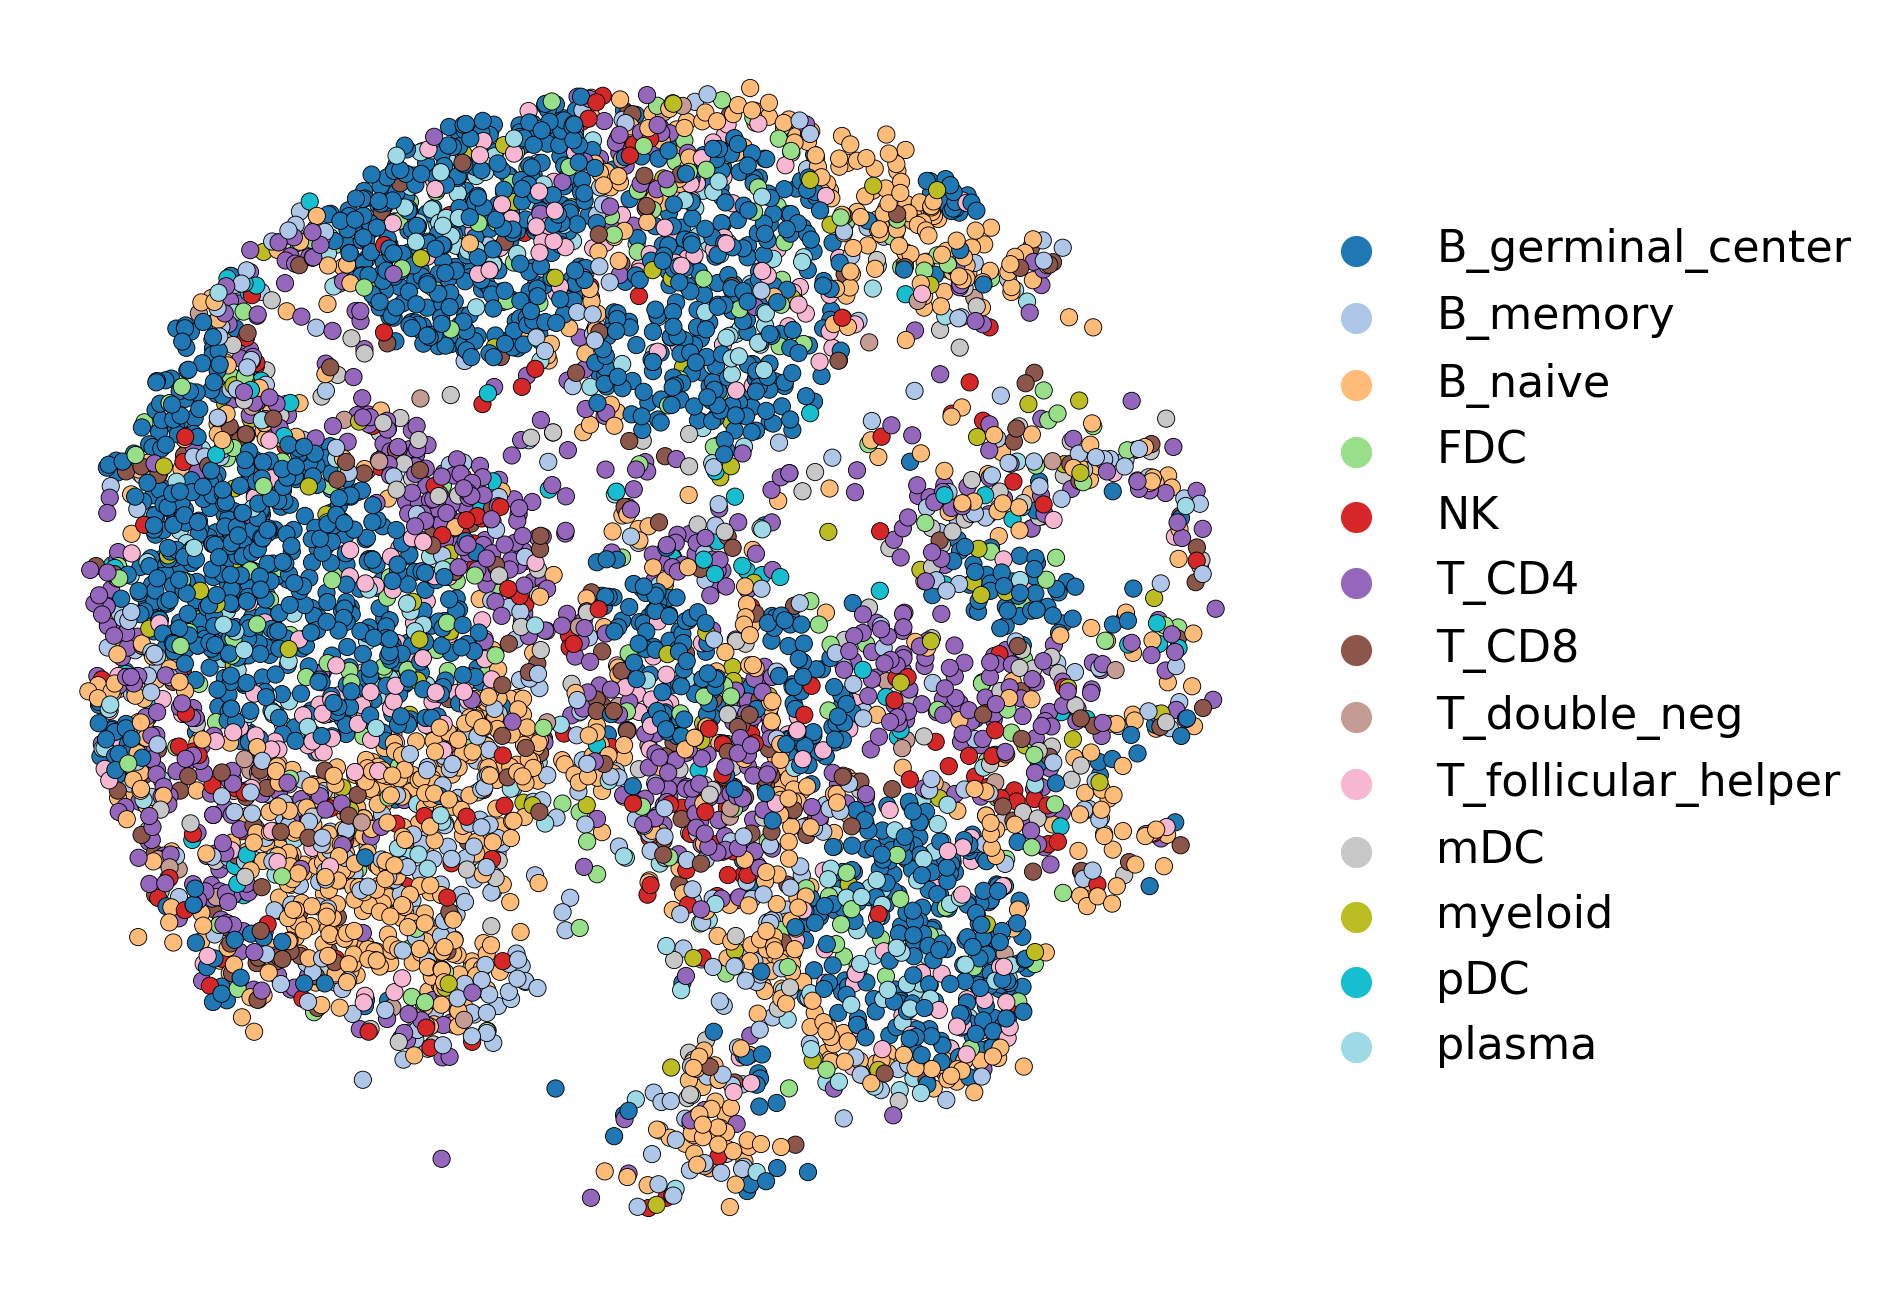

<Figure size 800x800 with 0 Axes>

In [6]:
plt.rcParams['figure.figsize'] = [5, 5]
plt.rcParams['figure.dpi'] = 160
sc.pl.embedding(adata, basis='spatial', 
    color='cell_type', frameon=False, title='', 
    legend_loc='right margin', size=60, add_outline=False, palette='tab20', 
    outline_width=(0.2, 0.1), linewidth=0.2, edgecolor='black')

plt.savefig('tonsil_celltypes.png', dpi=300, bbox_inches='tight', transparent=True, format='svg')

In [8]:
sys.path.append('/ix3/djishnu/alw399/SpaceOracle/src')

In [9]:
from spaceoracle.prophets import Prophet
from spaceoracle.plotting.cartography import xy_from_adata
from spaceoracle.plotting.cartography import Cartography
from spaceoracle.gene_factory import GeneFactory


2025-06-12 18:06:51.710482: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /ihome/crc/install/gcc-12.2.0/postgresql/15.2/lib:/ihome/crc/install/gcc-12.2.0/imagemagick/6.9.12/lib:/ihome/crc/install/gcc-12.2.0/geos/3.9.4/lib:/ihome/crc/install/gcc-12.2.0/zstd/zstd-1.5.5/lib:/ihome/crc/install/gcc-12.2.0/unixodbc/2.3.11/lib:/ihome/crc/install/sodium/1.0.18/lib:/ihome/crc/install/gcc-12.2.0/r/4.4.0/lib64/R/lib:/ihome/crc/install/gcc-12.2.0/openmpi/4.1.5/lib:/ihome/crc/install/gcc-12.2.0/fftw/3.3.10/lib:/ihome/crc/install/gcc-12.2.0/glpk/5.0/lib:/ihome/crc/install/gcc-12.2.0/proj/4.9.3/lib:/ihome/crc/install/gcc-12.2.0/gdal/2.4.4/lib:/ihome/crc/install/gcc-12.2.0/netcdf/4.8.1/lib:/ihome/crc/install/gcc-12.2.0/hdf5/1.14.0/lib:/ihome/crc/install/gcc-12.2.0/jags/4.3.2/lib:/ihome/crc/install/gcc-12.2.0/gsl/2.7.1/lib:/ihome/c

In [10]:
xy = xy_from_adata(adata)
adata.obs.cell_type.value_counts()

cell_type
B_germinal_center      1848
B_naive                1067
T_CD4                   779
B_memory                516
T_follicular_helper     294
plasma                  262
FDC                     255
T_CD8                   238
NK                      170
mDC                     137
myeloid                 102
pDC                      64
T_double_neg             46
Name: count, dtype: int64

In [11]:
gf = GeneFactory.from_json(
    adata, 
    '/ix/djishnu/shared/djishnu_kor11/scGPT_runs/tonsil_pretrained/run_params.json', 
)

gf.load_betas(float16=True, obs_names=None)

In [12]:
genes = ['S1PR4', 'S1PR2', 'PDCD11', 'TRAF3', 'IL2', 'GATA2', 'STAT1', 'NFKBIZ', 'NFKBIB', 
         'NFKBIE', 'PDCD1LG2', 'SATB1', 'SDF2L1', 'STAT6', 'NFKBIL1', 'S1PR1', 'NFKB1', 'SDF2', 
         'NFKBID', 'IL4RA', 'TICAM1', 'SDF4', 'VCAM1', 'STAT4', 'NFKB2', 'PAX5', 'STAT3', 
         'AICDA', 'S1PR3', 'NFKBIA', 'TICAM2']


genes = [g for g in np.unique(genes) if g in adata.var_names]
len(genes)


28

In [13]:
from tqdm import tqdm
for gene in tqdm(genes):
    gex_out = gf.perturb(
        target=gene, 
        n_propagation=4,
        gene_expr=0
    )

    gex_out.to_parquet(
        f'/ix/djishnu/shared/djishnu_kor11/genome_screens/human_tonsil_scGPT_pretrained/{gene}_4n_0x.parquet'
    )

KeyboardInterrupt: 

In [15]:
max_expr = adata[:, 'IL21'].layers['imputed_count'].max()
max_expr.item()

0.9892565953798496

In [16]:
gex_out = gf.perturb(
    target='IL21', 
    n_propagation=4,
    gene_expr=max_expr.item()
)

gex_out.to_parquet(
    '/ix/djishnu/shared/djishnu_kor11/genome_screens/human_tonsil_scGPT_pretrained/IL21_4n_maxx.parquet'
)